In [1]:
import cmath
import control
from control.matlab import step
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

### Projeto 2 de Controle
#### Aluno: Eric Monteiro dos Reis


In [2]:
NT = 19 #EricMonteirodosReis
R1 = 2000*NT
R2 = 18000
C1 = 100e-9 
C2 = 680e-9

In [3]:
A = np.matrix([[-1/(R2*C1), 1/(R2*C1)], [-1/(R2*C1) + 1/(R2*C2), -1/(R1*C2) + 1/(R2*C1) - 1/(R2*C2)]])
B = np.matrix([[0], [1/(R1*C2)]])
C =  np.matrix('1, 0')
D = np.matrix('0')

In [4]:
G = control.ss(A,B,C,D)
G

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

In [5]:
system = control.ss2tf(G)
system

TransferFunction(array([-5.68434189e-14,  2.14998280e+04]), array([1.00000000e+00, 1.20399037e+02, 2.14998280e+04]))

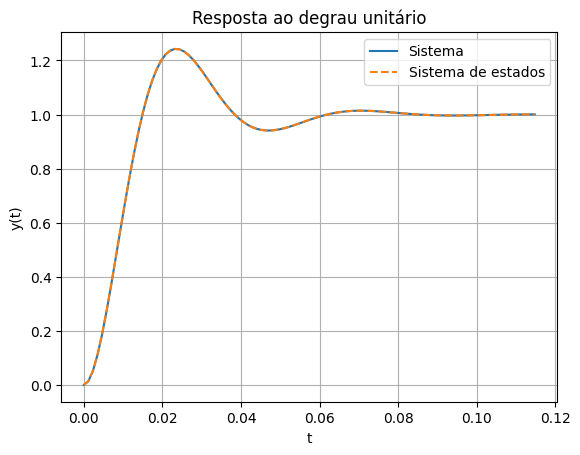

In [6]:
x, y = control.step_response(system)
x2, y2 = control.step_response(G)
plt.figure()
plt.plot(x, y, label='Sistema')
plt.plot(x2, y2, ls= '--', label='Sistema de estados')
plt.title("Resposta ao degrau unitário")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Verificando polos da planta
eigenvalues, eigenvectors = linalg.eig(A);
poles = eigenvalues
print(poles)

[-60.1995184+133.70058334j -60.1995184-133.70058334j]


#### Projeto do Controlador

In [8]:
Ts5 = NT *1e-3
Mp = len('Eric')*2/100

# Adotando 10 vezes como escolha, temos Ts = Ts5/10 = 19ms/10 = 1.9ms
Ts = Ts5/10
Fs = 1/Ts

zeta = math.sqrt(math.log(Mp)**2/(math.log(Mp)**2 + math.pi**2))
wn = 3/(zeta*(Ts5))
wd = wn*math.sqrt(1-(zeta**2))
ws = 2*math.pi/Ts

ws_wd_relation = ws/wd

# Polos dominantes desejados

s1 = -zeta*wn + 1j*wd
s2 = -zeta*wn - 1j*wd
s3 = -10*abs(s1);


print(f'zeta: {zeta}')
print(f'wd: {wd}')
print(f'wn: {wn}')
print(f'Ts: {Ts}')
print(f'Fs: {Fs}')
print(f'\nPolos:\ns1 = {s1}\ns2 = {s2}\ns3 = {s3}')

zeta: 0.6265771868559205
wd: 196.39518537412278
wn: 251.99566813850933
Ts: 0.0019
Fs: 526.3157894736842

Polos:
s1 = (-157.8947368421053+196.39518537412278j)
s2 = (-157.8947368421053-196.39518537412278j)
s3 = -2519.9566813850934


In [9]:
# Não é possível realizarmos uma ação de controle em sistemas não lineares, por isso essa verificação

# Matriz de Controlabilidade
Mc = control.ctrb(A,B)
Mc

# Teste de Controlabilidade
rank_Mc = np.linalg.matrix_rank(Mc) 

if len(Mc) == rank_Mc:          
    print("O sistema é controlável")

O sistema é controlável


In [15]:
# Equação característica desejada
eq_des = np.poly([s1, s2, s3]);
eq_des

# Matrizes Expandidas
A_controle = np.block([[A, np.zeros([2,1])],[-C, 0]]);
B_controle = np.block([[B],[0]]);

# Matriz de ganhos do controlador K_chapeu = [k1 k2 -ki]
K_controle = control.acker(A_controle,B_controle,[s1, s2, s3])
K_controle

#Utilizando a formula do slide para termos o sistema expandido
K = np.block([K_controle[0,0], K_controle[0,1] ])
Ki = -K_controle[0,2]
AA = np.block([[A-B*K, B*Ki],[-C,0]])
BB = np.block([[0],[0],[1]])
CC = np.block([1, 0, 0])
DD = 0;

controlled_sys = control.ss(AA,BB,CC,DD);

In [16]:
print(K)

[-31.1978493   70.16456954]


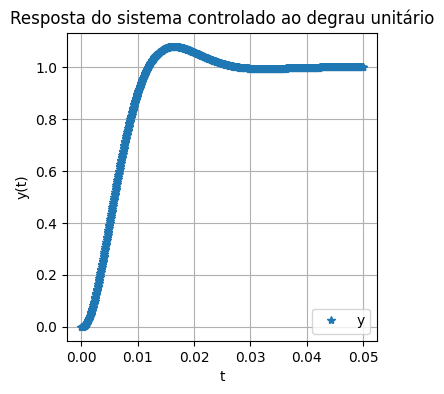

In [17]:
# resposta para entrada ao degrau do sistema controlado
t_final = 0.05 
Y_ctrld, t_y_ctrld = control.matlab.step(controlled_sys,tfinal);

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(4,4)

ax1.plot(t_y_ctrld,Y_ctrld,'*')
ax1.set_title("Resposta do sistema controlado ao degrau unitário")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")
ax1.legend(['y'],loc="lower right")
ax1.grid(True,'both')


In [18]:
# Sobressinal percentual
Mp = (max(Y_ctrld)-Y_ctrld[-1])/(Y_ctrld[-1]-Y_ctrld[0]);
print(f'Mp = {Mp*100}%')

# Tempo de acomodação para 5%

j = len(t_y_ctrld)-1;
delta = 0;
while (delta < t_final):
    delta = abs((Y_ctrld[j]-Y_ctrld[-1])/Y_ctrld[-1]);
    ts = t_y_ctrld[j];
    j = j-1;
   
print(f'\nTs5% = {ts*1000}ms')

Mp = 7.905398232815069%

Ts5% = 20.755750273822564ms


In [19]:
#eq. recursivas

#t = t_y_ctrld


Fs = Fs*10 #2500
Ts = 1/Fs
tfinal = 0.05;

Kmax = int((tfinal/Ts)+1);

t =np.linspace(0, tfinal, Kmax);
r = np.ones(len(t));
r[0] = 0;

# declaração dos vetores
x1 = np.zeros(len(t));
x2 = np.zeros(len(t));
csi = np.zeros(len(t));

u = np.zeros(len(t));

x1_ponto = np.zeros(len(t));
x2_ponto = np.zeros(len(t));
csi_ponto = np.zeros(len(t));
y = np.zeros(len(t));

y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0

for j in range(0,len(t)):
    # Equações dos integradores
    x1[j] = Ts*x1_ponto[j-1] + x1[j-1];
    x2[j] = Ts*x2_ponto[j-1] + x2[j-1];    
    csi[j] = Ts*csi_ponto[j-1] + csi[j-1];

    # Equação da lei de controle
    u[j] = -(K[0]*x1[j] + K[1]*x2[j]) + Ki*csi[j];

    # Equação diferencial de estados:  Xponto=A*X+B*U
    x1_ponto[j] = A[0,0]*x1[j] + A[0,1]*x2[j] + B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j] + A[1,1]*x2[j] + B[1]*u[j]; 

    # Equação de Saída: Y=C*X+D*U
    y[j] = C[0,0]*x1[j]# + C[1]*x2[j]# + D*u[j];

    # Equação de erro
    csi_ponto[j] = r[j] - y[j];

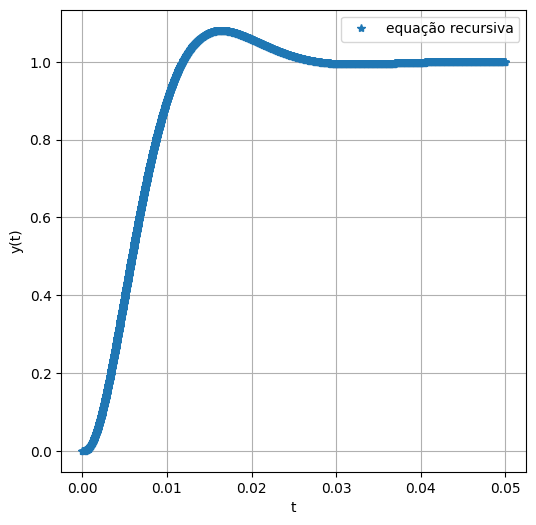

In [20]:
# comportamento da saída y                      
fig = plt.figure()
fig.set_size_inches(6,6)
plt.plot( t, y,'*')#t_y_ctrld, Y_ctrld,'-')#
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(['equação recursiva'],loc="upper right")
plt.grid(True)
plt.show()

In [ ]:
fig, ((ax1, ax2) ) = plt.subplots(1, 2)
fig.set_size_inches(10,5)

ax1.plot(t, x1,'*')
ax1.set_title("Comportamento do estado x1 ")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1'],loc="lower right")
ax1.grid(True)

ax2.plot(t, x2,'*')
ax2.set_title("Comportamento do estado x2")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2'],loc="lower right")
ax2.grid(True)

#### Observador de ordem plena

In [ ]:
# Matriz de observabilidade

N = np.block([np.conjugate(np.transpose(C)),np.conjugate(np.transpose(A))*np.conjugate(np.transpose(C))]);
                                                 
# teste de observabilidade
rank_Mo = np.linalg.matrix_rank(N)   

if len(N) == rank_Mo:          
    print("O sistema é controlável")

In [ ]:
# Verificando polos da planta
eigenvalues, eigenvectors = linalg.eig(A);

# Polos escolhidos de forma que o observador tenha o dobro da velocidade do controlador
s1_obs = -2*abs(s1)
s2_obs = -2*abs(s2)

print(f'Polos do observador: \n\ns1: {s1_obs}\ns2:{s2_obs}')


In [ ]:
# Matriz de Ganhos do Observador
Ke = np.transpose(control.acker(np.transpose(A),np.transpose(C),[s1_obs, s2_obs]))
Ke

In [ ]:
# Verificação através do sistema expandido

AA = np.block([[A, np.zeros([len(A),len(A)])],[Ke*C, A-Ke*C]]);
BB = np.block([[B],[B]]);
CC = np.eye(2*len(A));
DD = np.zeros([2*len(A),1])

system_obs = control.ss(AA,BB,CC,DD);

In [ ]:
# resposta para entrada ao degrau
Y_obs, t_y_obs = control.matlab.step(system_obs,0.15);

# separando os elemntos do vetor X
x1 = Y_obs[:,0];
x2 = Y_obs[:,1];
x1e = Y_obs[:,2];
x2e = Y_obs[:,3];


fig, ((ax1, ax2) ) = plt.subplots(1, 2)
fig.set_size_inches(15,5)

ax1.plot(t_y_obs, x1, t_y_obs, x1e,'*')
ax1.set_title("Comportamento do estado x1 e x1 observado")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1','X~1'],loc="lower right")
ax1.grid(True)

ax2.plot(t_y_obs, x2, t_y_obs, x2e,'*')
ax2.set_title("Comportamento do estado x2 e x2 observado")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2','X~2'],loc="lower right")
ax2.grid(True)

In [ ]:
tfinal = 0.15;

Kmax = int((tfinal/Ts)+1);

t =np.linspace(0, tfinal, Kmax);


u = np.ones(len(t+10));

# vetores de estados
x1_rec = np.zeros(len(t));
x2_rec = np.zeros(len(t));
x1_ponto_rec = np.zeros(len(t));
x2_ponto_rec = np.zeros(len(t));

# vetor de saída Y = C*X
y = np.zeros(len(t));

# vetores do observador de estatos
til_x1_rec = np.zeros(len(t));
til_x2_rec = np.zeros(len(t));
til_x1_ponto_rec = np.zeros(len(t));
til_x2_ponto_rec = np.zeros(len(t));

til_x1_ponto_rec[0]=B[0]*u[0];
til_x2_ponto_rec[0]=B[1]*u[0];

til_y = np.zeros(len(t));

# Equações da lei de controle
erro_1 = np.zeros(len(t));
erro_2 = np.zeros(len(t));

for j in range(0,Kmax-5):
    # Equações dos integradores
    x1_rec[j] = Ts*x1_ponto_rec[j-1] + x1_rec[j-1];
    x2_rec[j] = Ts*x2_ponto_rec[j-1] + x2_rec[j-1];
    til_x1_rec[j] = Ts*til_x1_ponto_rec[j-1] + til_x1_rec[j-1]
    til_x2_rec[j] = Ts*til_x2_ponto_rec[j-1] + til_x2_rec[j-1]
    
    # Equação de Saída: Y=C*X
    y[j] = C[0,0]*x1_rec[j] + C[0,1]*x2_rec[j];


    # Equação de Saída do observador : tilY=C*tilX
    til_y[j] = C[0,0]*til_x1_rec[j] + C[0,1]*til_x2_rec[j];

    #Equações da lei de controle
    erro_1[j] = Ke[0]*(y[j] - til_y[j]);
    erro_2[j] = Ke[1]*(y[j] - til_y[j]);

    # Equação diferencial de estados de x_ponto e til_x_ponto
    x1_ponto_rec[j] = A[0,0]*x1_rec[j] + A[0,1]*x2_rec[j] + B[0]*u[j];
    x2_ponto_rec[j] = A[1,0]*x1_rec[j] + A[1,1]*x2_rec[j] + B[1]*u[j];
    til_x1_ponto_rec[j] = A[0,0]*til_x1_rec[j] + A[0,1]*til_x2_rec[j] + B[0]*u[j] + erro_1[j];
    til_x2_ponto_rec[j] = A[1,0]*til_x1_rec[j] + A[1,1]*til_x2_rec[j] + B[1]*u[j] + erro_2[j];


In [ ]:
fig, ((ax1, ax2) ) = plt.subplots(2, 1)
fig.set_size_inches(5,10)

ax1.plot(t, x1_rec, 'g', t, til_x1_rec,'*')
ax1.set_title("x1 e x1 do observador utilizando recursivas")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1 recursiva','X~1 recursiva'],loc="upper right")
ax1.grid(True)

ax2.plot(t, x2_rec, 'g', t, til_x2_rec,'*')
ax2.set_title("x2 e x2 do observador utilizando recursivas")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2 recursiva','X~2 recursiva'],loc="upper right")
ax2.grid(True)

#### Sistema completo com controlador, observador e planta

In [ ]:
tfinal = 0.1;
Kmax = int((tfinal/Ts)+1);
t =np.linspace(0, tfinal, Kmax);
r = np.ones(int(len(t)/2));
r = np.concatenate((r, 1.5*r), axis=0)
csi = np.zeros(len(t));
csi_ponto = np.zeros(len(t));
u = np.zeros(len(t));

# vetores de estados
x1_rec = np.zeros(len(t));
x2_rec = np.zeros(len(t));
x1_ponto_rec = np.zeros(len(t));
x2_ponto_rec = np.zeros(len(t));

# vetor de saída Y = C*X
y = np.zeros(len(t));

# vetores do observador de estados
til_x1_rec = np.zeros(len(t));
til_x2_rec = np.zeros(len(t));
til_x1_ponto_rec = np.zeros(len(t));
til_x2_ponto_rec = np.zeros(len(t));
til_y = np.zeros(len(t));


# Realimentação de controle do observador
erro_1 = np.zeros(len(t));
erro_2 = np.zeros(len(t));

## Condições iniciais

csi_ponto[0] = r[0] - y[0]; 

x1_ponto_rec[0] = A[0,0]*x1_rec[0] + A[0,1]*x2_rec[0] + B[0]*u[0];
x2_ponto_rec[0] = A[1,0]*x1_rec[0] + A[1,1]*x2_rec[0] + B[1]*u[0];
til_x1_ponto_rec[0]=B[0]*u[0];
til_x2_ponto_rec[0]=B[1]*u[0];

for j in range(0,Kmax-1):
    # sistema original
    csi[j] = Ts*csi_ponto[j-1] + csi[j-1];
    x1_rec[j] = Ts*x1_ponto_rec[j-1] + x1_rec[j-1];
    x2_rec[j] = Ts*x2_ponto_rec[j-1] + x2_rec[j-1];

     # observador 
    til_x1_rec[j] = Ts*til_x1_ponto_rec[j-1] + til_x1_rec[j-1]
    til_x2_rec[j] = Ts*til_x2_ponto_rec[j-1] + til_x2_rec[j-1]
    
    # Equação de Saída: Y=C*X
    y[j] = C[0,0]*x1_rec[j];


    # Equação de erro
    csi_ponto[j] = r[j] - y[j];     


    # Equação da lei de controle
    u[j] = -(K[0]*til_x1_rec[j] + K[1]*til_x2_rec[j]) + Ki*csi[j];


        # Equação de Saída do observador : tilY=C*tilX
    til_y[j] = C[0,0]*til_x1_rec[j] + C[0,1]*til_x2_rec[j];

    #Equações da lei de controle
    erro_1[j] = Ke[0]*(y[j] - til_y[j]);
    erro_2[j] = Ke[1]*(y[j] - til_y[j]);


    # Equação diferencial de estados de x_ponto e til_x_ponto
    x1_ponto_rec[j] = A[0,0]*x1_rec[j] + A[0,1]*x2_rec[j] + B[0]*u[j];
    x2_ponto_rec[j] = A[1,0]*x1_rec[j] + A[1,1]*x2_rec[j] + B[1]*u[j];
    til_x1_ponto_rec[j] = A[0,0]*til_x1_rec[j] + A[0,1]*til_x2_rec[j] + B[0]*u[j] + erro_1[j];
    til_x2_ponto_rec[j] = A[1,0]*til_x1_rec[j] + A[1,1]*til_x2_rec[j] + B[1]*u[j] + erro_2[j];


fig, ((ax1, ax2) ) = plt.subplots(2, 1)
fig.set_size_inches(20,8)

ax1.plot(t, x1_rec, t, til_x1_rec,'*')
ax1.set_title("x1 e x1 do observador utilizando recursivas")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1 recursiva','X~1 recursiva'],loc="lower right")
ax1.grid(True)

ax2.plot(t, x2_rec, t, til_x2_rec,'*')
ax2.set_title("x2 e x2 do observador utilizando recursivas")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2 recursiva','X~2 recursiva'],loc="lower right")
ax2.grid(True)